In [43]:
import pandas as pd
import networkx as nx
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

# 1/ Load raw data
df = pd.read_csv('hero-network.csv')

# Make sure consistent ordering of pairs (since the graph is undirected)
df['pair'] = df.apply(lambda row: tuple(sorted([row['hero1'], row['hero2']])), axis=1)

# Count duplicates (co-appearances) as weight
pair_counts = df['pair'].value_counts().reset_index()
pair_counts.columns = ['pair', 'weight']
pair_counts[['hero1', 'hero2']] = pd.DataFrame(pair_counts['pair'].tolist(), index=pair_counts.index)

# Create weighted graph
G = nx.Graph()
for _, row in pair_counts.iterrows():
    G.add_edge(row['hero1'], row['hero2'], weight=row['weight'])

# Basic stats
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
degree_sequence = [d for _, d in G.degree()]
avg_degree = sum(degree_sequence) / num_nodes
std_degree = pd.Series(degree_sequence).std()
min_degree = min(degree_sequence)
max_degree = max(degree_sequence)

# Degree dataframe
degree_df = pd.DataFrame(G.degree(), columns=['character', 'degree'])
degree_df_sorted = degree_df.sort_values(by='degree', ascending=True)
degree_df_sorted.to_csv('hero_degrees_sorted.csv', index=False)

# Degree centrality
degree_centrality = nx.degree_centrality(G)
dc_series = pd.Series(degree_centrality)

max_dc = dc_series.idxmax(), dc_series.max()
min_dc = dc_series.idxmin(), dc_series.min()
avg_diff = (dc_series - dc_series.mean()).abs()
close_to_avg = dc_series[avg_diff.nsmallest(3).index].items()

# Output
print(f"Network Statistics:")
print(f"Total Nodes: {num_nodes}")
print(f"Total Edges (unique pairs): {num_edges}")
print(f"Average Degree: {avg_degree:.3f}")
print(f"Standard Deviation: {std_degree:.3f}")
print(f"Minimum Degree: {min_degree}")
print(f"Maximum Degree: {max_degree}\n")

print(f"Most Connected: {max_dc[0]} ({max_dc[1]:.5f})")
print(f"Least Connected: {min_dc[0]} ({min_dc[1]:.5f})")
print("\nClose to Average Centrality:")
for char, score in close_to_avg:
    print(f"{char}: {score:.5f}")


Network Statistics:
Total Nodes: 6426
Total Edges (unique pairs): 167219
Average Degree: 52.045
Standard Deviation: 113.658
Minimum Degree: 1
Maximum Degree: 1908

Most Connected: CAPTAIN AMERICA (0.29696)
Least Connected: DESADIA (0.00016)

Close to Average Centrality:
NEVILLE, KATE: 0.00809
PLUNDERER/LORD EDGAR: 0.00809
PEARSON, MARCY: 0.00809


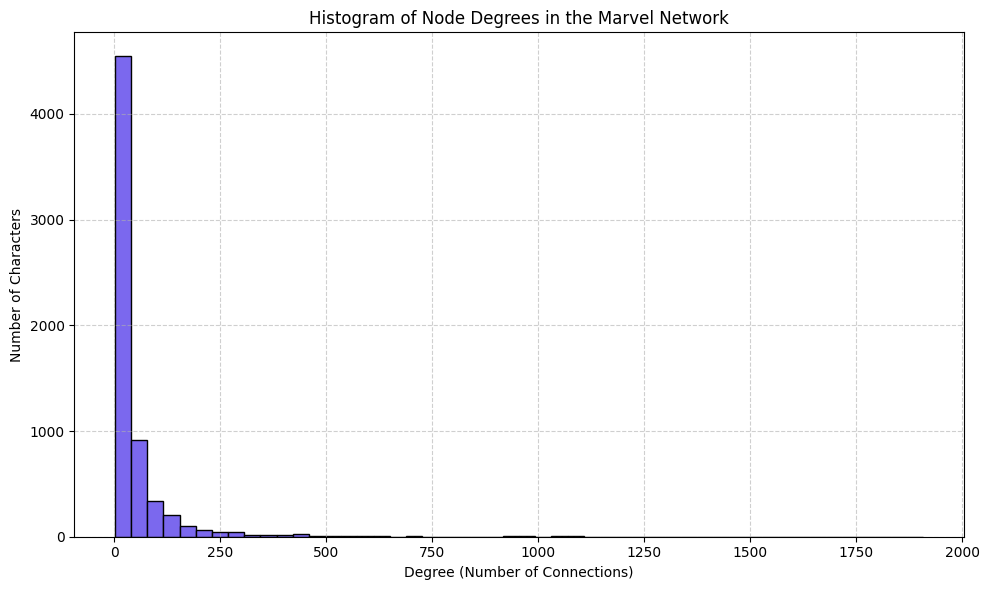

In [44]:
# Plot histogram of node degrees
plt.figure(figsize=(10, 6))
plt.hist(degree_sequence, bins=50, color='mediumslateblue', edgecolor='black')
plt.title("Histogram of Node Degrees in the Marvel Network")
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Number of Characters")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Edge Weight Range (excluding self-loops): min = 1, max = 1894


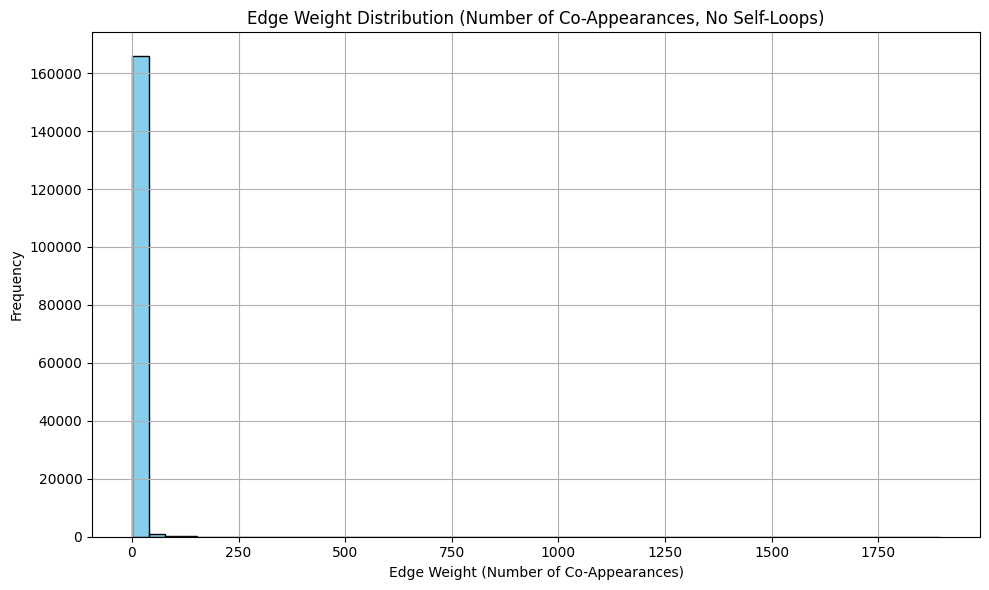

Saved edge weights (excluding self-loops) to hero_pair_weights.csv


In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Get all edge weights from the graph (excluding self-loops)
edge_weights = [d['weight'] for u, v, d in G.edges(data=True) if u != v]

# Print min and max weight
min_weight = min(edge_weights)
max_weight = max(edge_weights)
print(f"Edge Weight Range (excluding self-loops): min = {min_weight}, max = {max_weight}")

# Plot histogram of edge weights
plt.figure(figsize=(10, 6))
plt.hist(edge_weights, bins=50, color='skyblue', edgecolor='black')
plt.title("Edge Weight Distribution (Number of Co-Appearances, No Self-Loops)")
plt.xlabel("Edge Weight (Number of Co-Appearances)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract non-self-loop edges with weights into a DataFrame
edges_with_weights = pd.DataFrame([
    {'hero1': u, 'hero2': v, 'weight': d['weight']}
    for u, v, d in G.edges(data=True)
    if u != v
])

# Sort by weight descending
edges_with_weights = edges_with_weights.sort_values(by='weight', ascending=False)

# Save to CSV
edges_with_weights.to_csv('hero_pair_weights.csv', index=False)

print("Saved edge weights (excluding self-loops) to hero_pair_weights.csv")


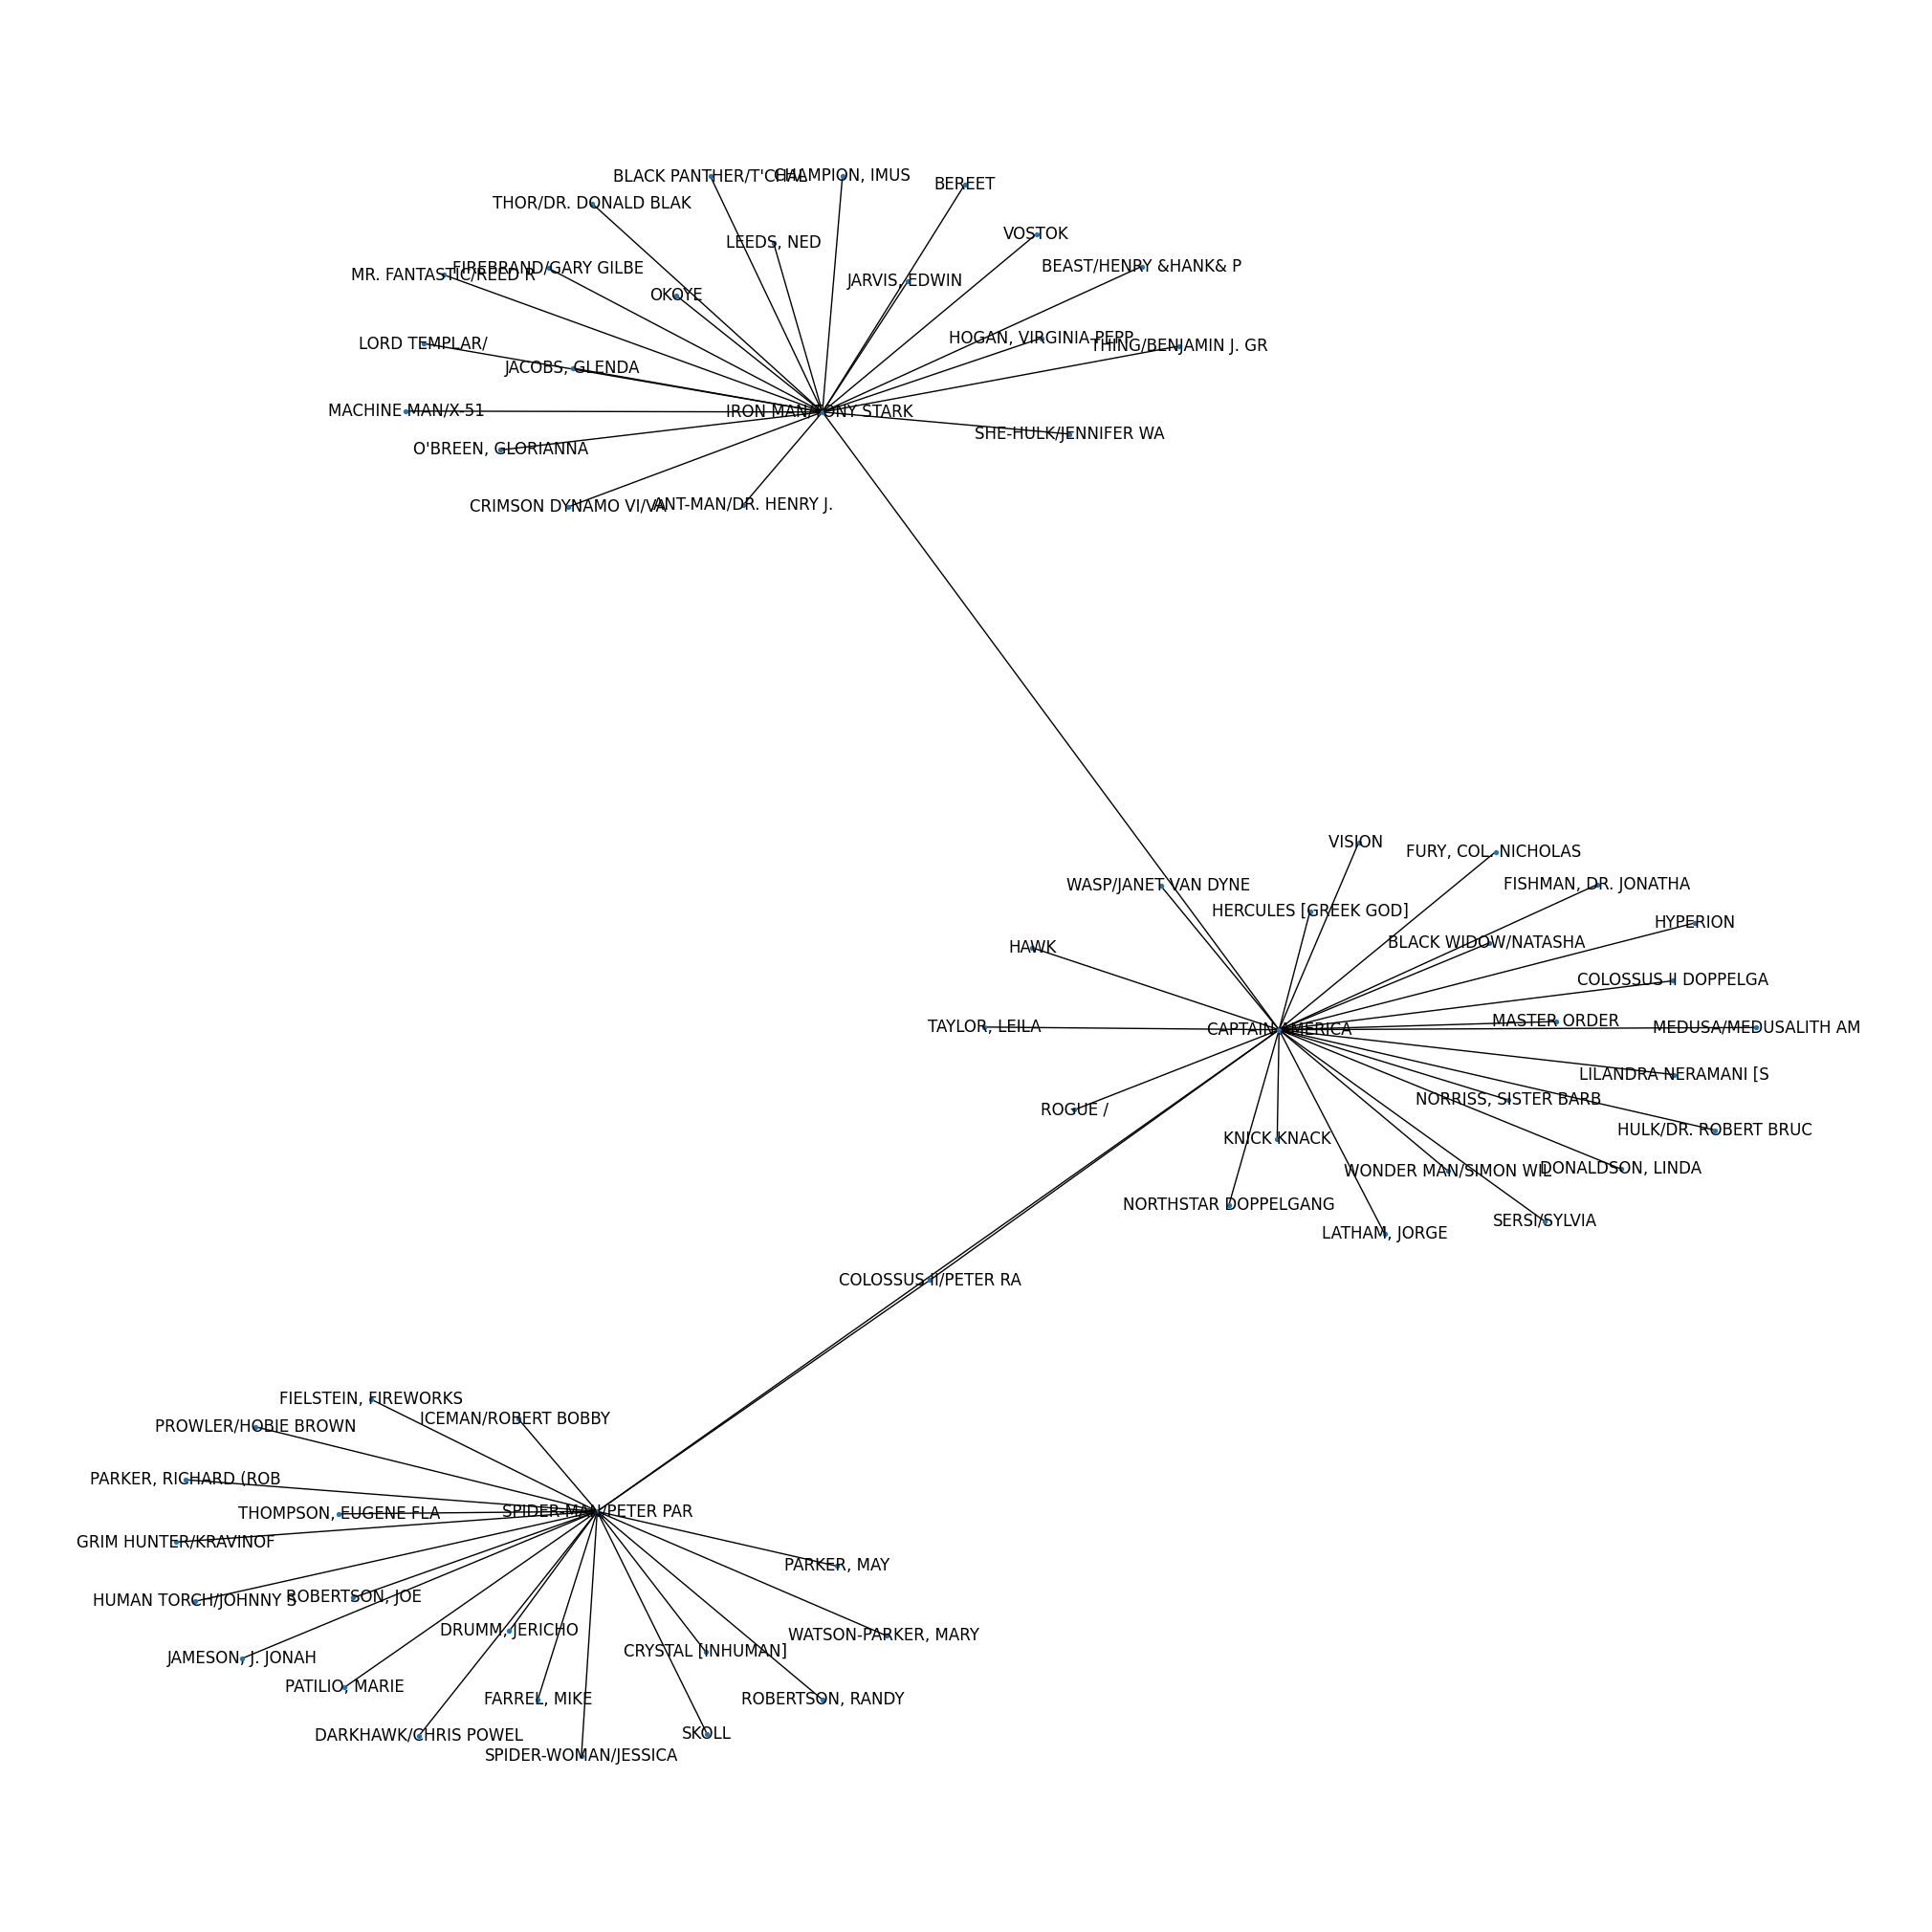

In [46]:
SpiderMan = df[df['hero1']=='SPIDER-MAN/PETER PAR'].sample(25)
Cap = Subset = df[df['hero1']=='CAPTAIN AMERICA'].sample(25)
IronMan = df[df['hero1'].str.contains('IRON MAN/TONY STARK')].sample(25)

Subset = pd.concat([SpiderMan,Cap,IronMan],axis = 0)

G1=nx.from_pandas_edgelist(Subset, 'hero1', 'hero2')
plt.figure(figsize = (20,20))
nx.draw(G1, with_labels=True, node_size = 8)
plt.show()

In [47]:
# 2/
deg_dict = dict(G.degree())

degree_to_nodes = {}
for node, deg in deg_dict.items():
    degree_to_nodes.setdefault(deg, []).append(node)

results = []
for k, nodes in sorted(degree_to_nodes.items()):
    if len(nodes) < 2:
        continue

    dists = []
    for u, v in combinations(nodes, 2):
        try:
            d = nx.shortest_path_length(G, source=u, target=v)
            dists.append(d)
        except nx.NetworkXNoPath:
            pass

    if len(dists) > 0:
        avg_dist = np.mean(dists)
        var_dist = np.var(dists, ddof=0)
    else:
        avg_dist = np.nan
        var_dist = np.nan

    results.append({
        'degree': k,
        'n_nodes': len(nodes),
        'avg_distance': avg_dist,
        'var_distance': var_dist
    })

dc_summary_df = pd.DataFrame(results).set_index('degree')
print(dc_summary_df)

#Save the summary to a CSV file
dc_summary_df.to_csv('same_degree_centrality_summary.csv')

        n_nodes  avg_distance  var_distance
degree                                     
1            53      3.270376      0.264671
2            86      3.260739      0.260606
3           104      3.226475      0.264056
4           150      3.104609      0.222704
5           182      3.139336      0.249968
...         ...           ...           ...
497           2      1.000000      0.000000
526           2      1.000000      0.000000
539           2      1.000000      0.000000
585           2      1.000000      0.000000
922           2      1.000000      0.000000

[242 rows x 3 columns]


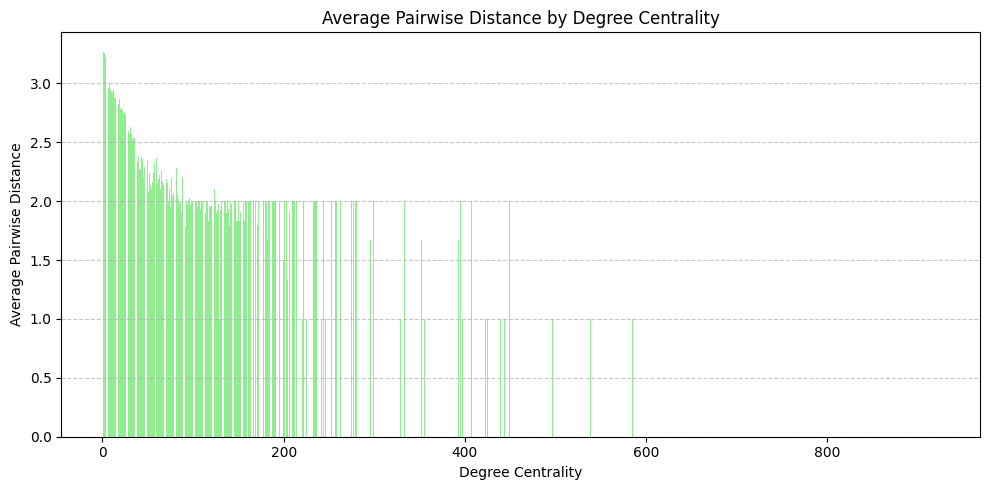

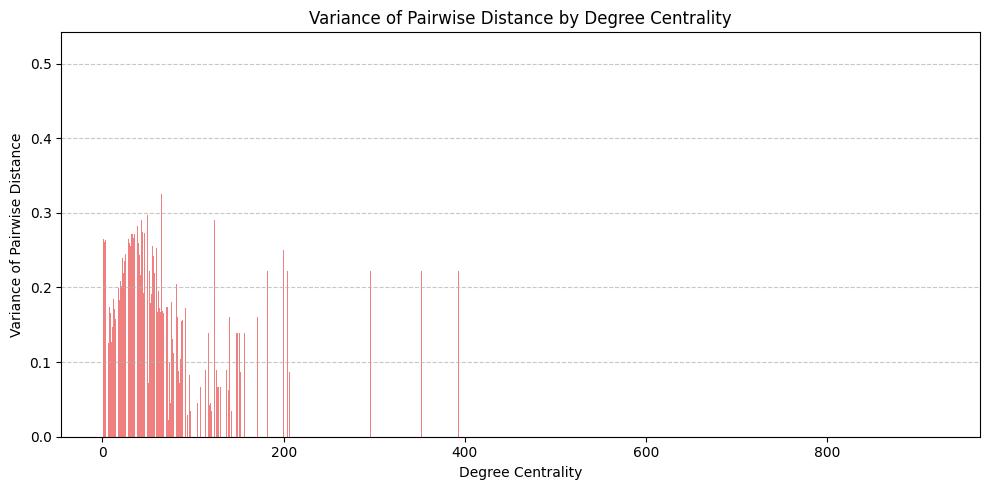

In [48]:
import matplotlib.pyplot as plt

# Bar plot for average pairwise distance
plt.figure(figsize=(10, 5))
plt.bar(dc_summary_df.index, dc_summary_df['avg_distance'], color='lightgreen')
plt.xlabel('Degree Centrality')
plt.ylabel('Average Pairwise Distance')
plt.title('Average Pairwise Distance by Degree Centrality')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Bar plot for variance of pairwise distance
plt.figure(figsize=(10, 5))
plt.bar(dc_summary_df.index, dc_summary_df['var_distance'], color='lightcoral')
plt.xlabel('Degree Centrality')
plt.ylabel('Variance of Pairwise Distance')
plt.title('Variance of Pairwise Distance by Degree Centrality')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [49]:
# 3/
results = []
for k, nodes in sorted(degree_to_nodes.items()):
    if len(nodes) < 2:
        continue

    sims = []
    for u, v in combinations(nodes, 2):
        nbrs_u = set(G.neighbors(u))
        nbrs_v = set(G.neighbors(v))
        if k > 0:
            sim = len(nbrs_u & nbrs_v) / np.sqrt(k * k)
            sims.append(sim)

    if sims:
        avg_sim  = np.mean(sims)
        std_sim  = np.std(sims, ddof=0)
    else:
        avg_sim, std_sim = np.nan, np.nan

    results.append({
        'degree':    k,
        'n_nodes':   len(nodes),
        'avg_sim':   avg_sim,
        'std_sim':   std_sim
    })

dc_struct_df = pd.DataFrame(results).set_index('degree')
print(dc_struct_df)

#Save the summary to a CSV file
dc_struct_df.to_csv('degree_structural_equivalence.csv')

        n_nodes   avg_sim   std_sim
degree                             
1            53  0.023948  0.152886
2            86  0.014227  0.087931
3           104  0.011265  0.073284
4           150  0.017651  0.085114
5           182  0.016356  0.087057
...         ...       ...       ...
497           2  0.382294  0.000000
526           2  0.359316  0.000000
539           2  0.278293  0.000000
585           2  0.213675  0.000000
922           2  0.427332  0.000000

[242 rows x 3 columns]


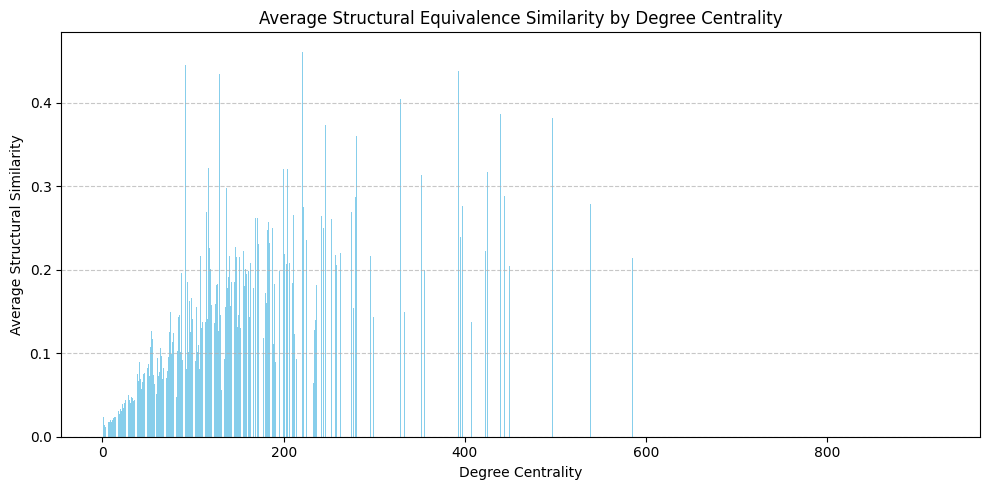

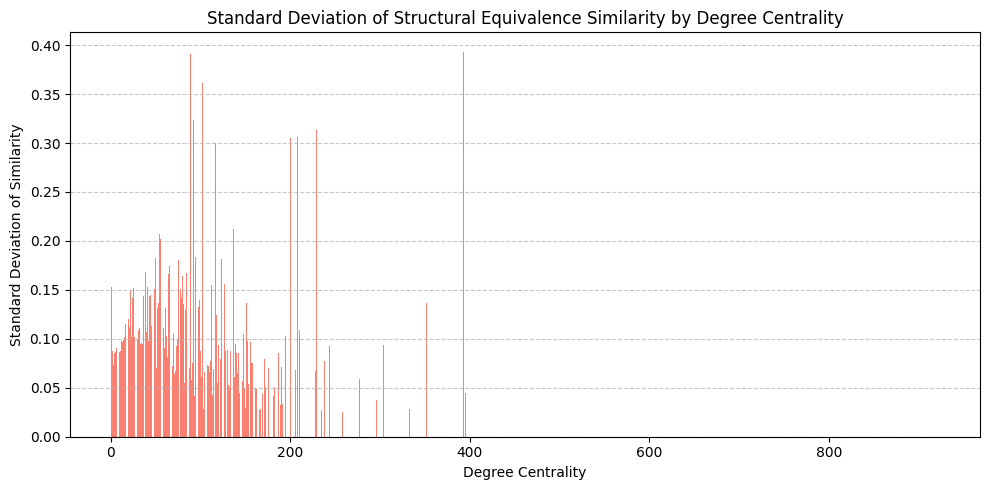

In [50]:
import matplotlib.pyplot as plt

# Bar plot for average similarity
plt.figure(figsize=(10, 5))
plt.bar(dc_struct_df.index, dc_struct_df['avg_sim'], color='skyblue')
plt.xlabel('Degree Centrality')
plt.ylabel('Average Structural Similarity')
plt.title('Average Structural Equivalence Similarity by Degree Centrality')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Bar plot for standard deviation of similarity
plt.figure(figsize=(10, 5))
plt.bar(dc_struct_df.index, dc_struct_df['std_sim'], color='salmon')
plt.xlabel('Degree Centrality')
plt.ylabel('Standard Deviation of Similarity')
plt.title('Standard Deviation of Structural Equivalence Similarity by Degree Centrality')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [51]:
# 4.1/
closeness_centrality = nx.closeness_centrality(G)
cc_series = pd.Series(closeness_centrality)

# Task 4.1: Global
cmean = cc_series.mean()
cstd = cc_series.std()
max_cc = (cc_series.idxmax(), cc_series.max())
min_cc = (cc_series.idxmin(), cc_series.min())
avg_diff_cc = (cc_series - cmean).abs()
close_to_avg_cc = cc_series[avg_diff_cc.nsmallest(3).index]

print("\nNetwork Statistics (Closeness Centrality):")
print(f"Mean: {cmean:.5f}")
print(f"Standard Deviation: {cstd:.5f}")
print(f"Most Central (Closeness): {max_cc[0]} ({max_cc[1]:.5f})")
print(f"Least Central (Closeness): {min_cc[0]} ({min_cc[1]:.5f})")
print("Close to Average Closeness Centrality:")
for char, score in close_to_avg_cc.items():
    print(f"- {char}: {score:.5f}")


Network Statistics (Closeness Centrality):
Mean: 0.38131
Standard Deviation: 0.04715
Most Central (Closeness): CAPTAIN AMERICA (0.58369)
Least Central (Closeness): MASTER OF VENGEANCE (0.00016)
Close to Average Closeness Centrality:
- SLEEPER: 0.38132
- AQUARIUS II/: 0.38132
- PROSH: 0.38123


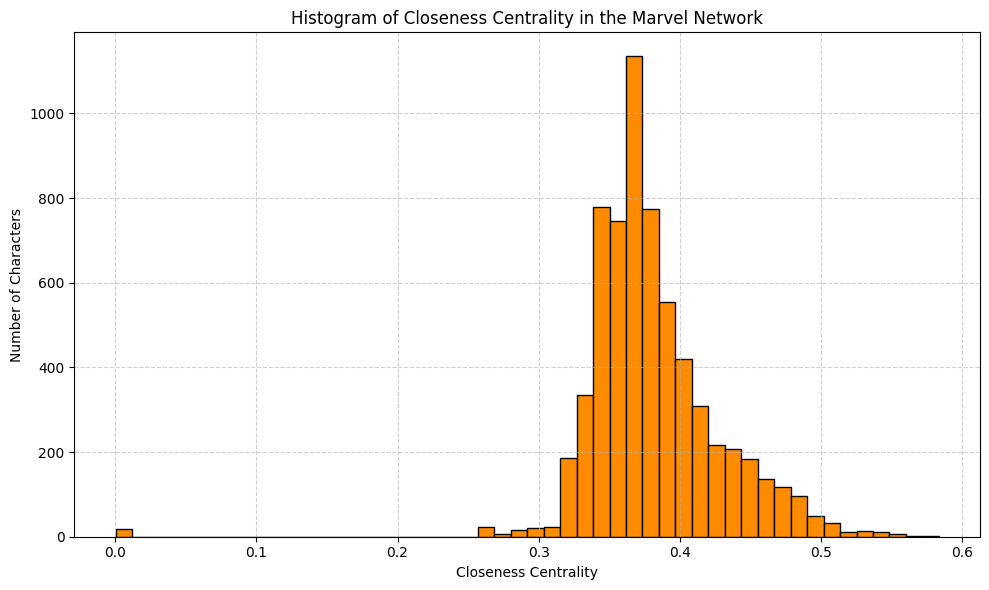

In [52]:
# Plot histogram of closeness centrality
plt.figure(figsize=(10, 6))
plt.hist(cc_series, bins=50, color='darkorange', edgecolor='black')
plt.title("Histogram of Closeness Centrality in the Marvel Network")
plt.xlabel("Closeness Centrality")
plt.ylabel("Number of Characters")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [53]:
# 4.2/
results_cc_dist = []
for val in sorted(set(cc_series.values)):
    group = [n for n, c in closeness_centrality.items() if c == val]
    if len(group) < 2:
        results_cc_dist.append({'centrality_value': val, 'avg_distance': np.nan, 'variance': np.nan})
    else:
        dists = []
        for u, v in combinations(group, 2):
            try:
                d = nx.shortest_path_length(G, source=u, target=v)
                dists.append(d)
            except nx.NetworkXNoPath:
                continue
        dists = np.array(dists)
        results_cc_dist.append({
            'centrality_value': val,
            'avg_distance': dists.mean() if dists.size else np.nan,
            'variance': dists.var(ddof=0) if dists.size else np.nan
        })
cc_summary_df = pd.DataFrame(results_cc_dist)
print("\nAverage Distance by Closeness Centrality:")
print(cc_summary_df.to_string(index=False))

# save the summary to a CSV file
cc_summary_df.to_csv('same_closeness_centrality_summary.csv', index=False)


Average Distance by Closeness Centrality:
 centrality_value  avg_distance  variance
         0.000156      1.000000  0.000000
         0.000934      1.000000  0.000000
         0.000996           NaN       NaN
         0.001107      1.000000  0.000000
         0.001245      1.000000  0.000000
         0.259675      1.000000  0.000000
         0.260501           NaN       NaN
         0.262309      2.000000  0.000000
         0.262319      1.666667  0.222222
         0.262330           NaN       NaN
         0.263901      1.000000  0.000000
         0.264262           NaN       NaN
         0.264272      1.000000  0.000000
         0.264283      1.000000  0.000000
         0.264404           NaN       NaN
         0.267615           NaN       NaN
         0.268143           NaN       NaN
         0.272652           NaN       NaN
         0.276247      1.000000  0.000000
         0.285953      1.000000  0.000000
         0.288575           NaN       NaN
         0.288588      1.000000  

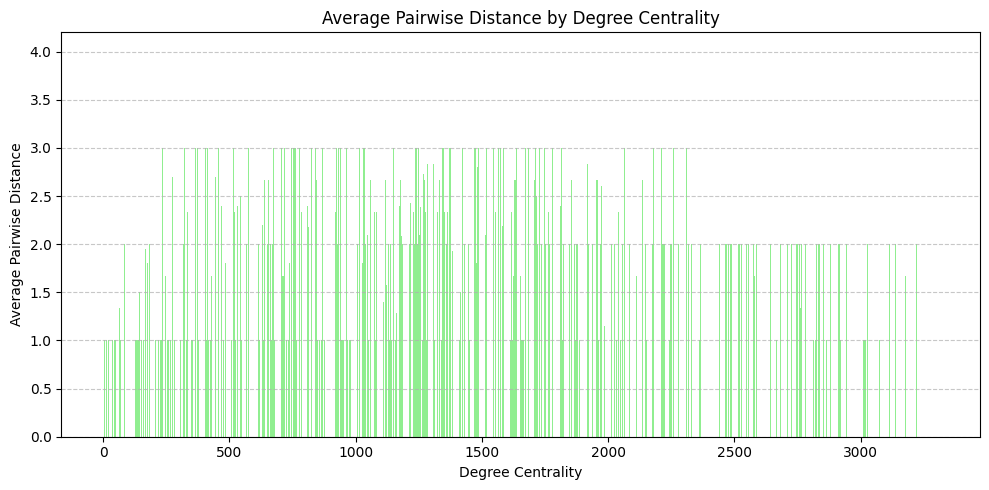

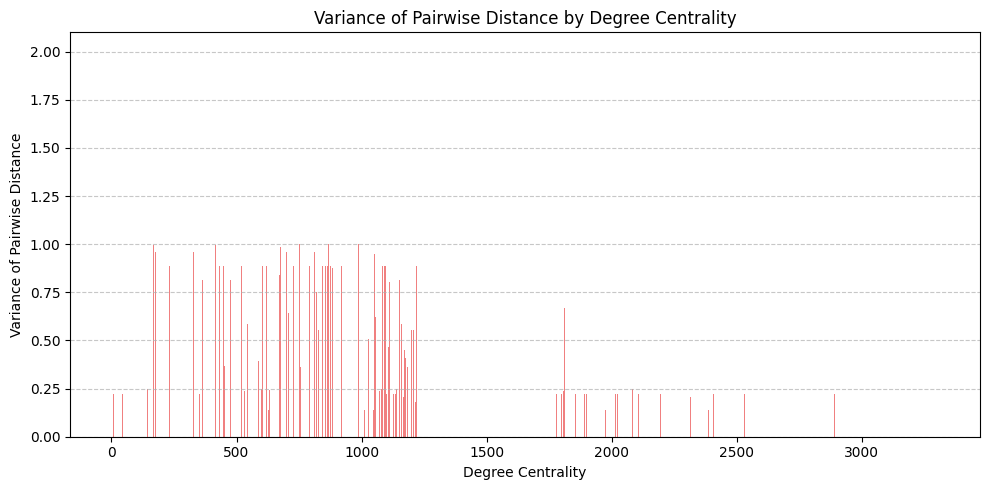

In [ ]:
import matplotlib.pyplot as plt

# Bar plot for average pairwise distance
plt.figure(figsize=(10, 5))
plt.bar(cc_summary_df.index, cc_summary_df['avg_distance'], color='lightgreen')
plt.xlabel('Closeness Centrality')
plt.ylabel('Average Pairwise Distance')
plt.title('Average Pairwise Distance by Closeness Centrality')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Bar plot for variance of pairwise distance
plt.figure(figsize=(10, 5))
plt.bar(cc_summary_df.index, cc_summary_df['variance'], color='lightcoral')
plt.xlabel('Closeness Centrality')
plt.ylabel('Variance of Pairwise Distance')
plt.title('Variance of Pairwise Distance by Closeness Centrality')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [55]:
# 4.3/
nodes = list(G.nodes())
node_to_idx = {n: i for i, n in enumerate(nodes)}
A = nx.to_numpy_array(G, nodelist=nodes)

# 4.3/
results_cc_struct = []
for val in sorted(set(closeness_centrality.values())):
    group = [n for n, c in closeness_centrality.items() if c == val]
    idxs = [node_to_idx[n] for n in group if n in node_to_idx]
    sims = []
    for i, j in combinations(idxs, 2):
        u = A[i]
        v = A[j]
        norm_u = np.linalg.norm(u)
        norm_v = np.linalg.norm(v)
        sim = np.dot(u, v) / (norm_u * norm_v) if norm_u and norm_v else 0.0
        sims.append(sim)
    sims = np.array(sims)
    results_cc_struct.append({
        'centrality_value': val,
        'avg_similarity': sims.mean() if sims.size > 0 else np.nan,
        'std_similarity': sims.std(ddof=0) if sims.size > 0 else np.nan
    })
cc_struct_df = pd.DataFrame(results_cc_struct)
print("\nStructural Equivalence by Closeness Centrality:")
print(cc_struct_df.to_string(index=False))

# save the summary to a CSV file
cc_struct_df.to_csv('closeness_structural_equivalence.csv', index=False)



Structural Equivalence by Closeness Centrality:
 centrality_value  avg_similarity  std_similarity
         0.000156        0.000000    0.000000e+00
         0.000934        0.833333    0.000000e+00
         0.000996             NaN             NaN
         0.001107        0.857143    0.000000e+00
         0.001245        0.826087    2.220446e-16
         0.259675        0.666667    1.110223e-16
         0.260501             NaN             NaN
         0.262309        0.750000    0.000000e+00
         0.262319        0.800000    0.000000e+00
         0.262330             NaN             NaN
         0.263901        0.709677    1.110223e-16
         0.264262             NaN             NaN
         0.264272        0.750000    0.000000e+00
         0.264283        0.636364    0.000000e+00
         0.264404             NaN             NaN
         0.267615             NaN             NaN
         0.268143             NaN             NaN
         0.272652             NaN             NaN
 

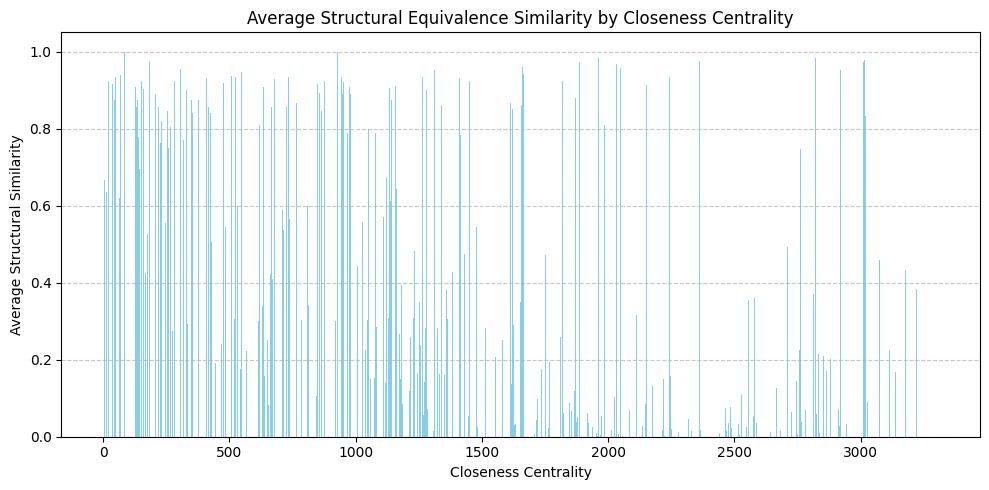

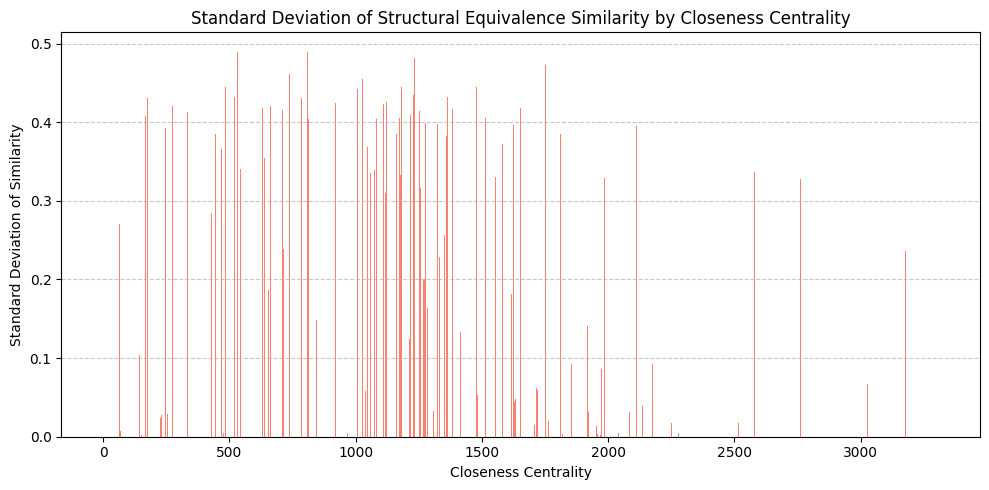

In [56]:
import matplotlib.pyplot as plt

# Bar plot for average similarity
plt.figure(figsize=(10, 5))
plt.bar(cc_struct_df.index, cc_struct_df['avg_similarity'], color='skyblue')
plt.xlabel('Closeness Centrality')
plt.ylabel('Average Structural Similarity')
plt.title('Average Structural Equivalence Similarity by Closeness Centrality')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Bar plot for standard deviation of similarity
plt.figure(figsize=(10, 5))
plt.bar(cc_struct_df.index, cc_struct_df['std_similarity'], color='salmon')
plt.xlabel('Closeness Centrality')
plt.ylabel('Standard Deviation of Similarity')
plt.title('Standard Deviation of Structural Equivalence Similarity by Closeness Centrality')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# 5/
components = list(nx.connected_components(G))
components_sorted = sorted(components, key=len, reverse=True)
largest_comp_nodes = components_sorted[0]
G_largest = G.subgraph(largest_comp_nodes)
diameter_largest = nx.diameter(G_largest)

print(f"Total number of connected components: {len(components)}")
print("Sizes of the 3 largest components:", [len(c) for c in components_sorted[:3]])
print(f"Diameter of the largest component: {diameter_largest}")

Total number of connected components: 4
Sizes of the 3 largest components: [6408, 9, 7]
Diameter of the largest component: 5


Because there are more than 1 components, the diameter of the graph cannot be calculated


In [68]:
print(f"Total number of connected components: {len(components)}")
print("Sizes of the components:", [len(c) for c in components_sorted])
print(f"Diameter of the largest component: {diameter_largest}")

Total number of connected components: 4
Sizes of the components: [6408, 9, 7, 2]
Diameter of the largest component: 5


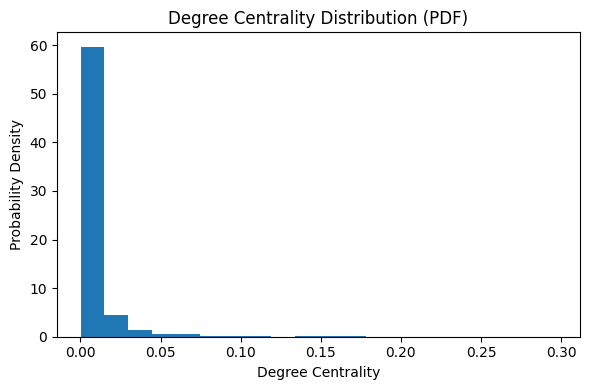

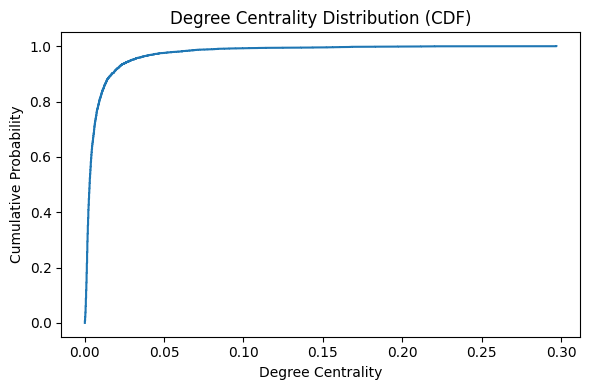

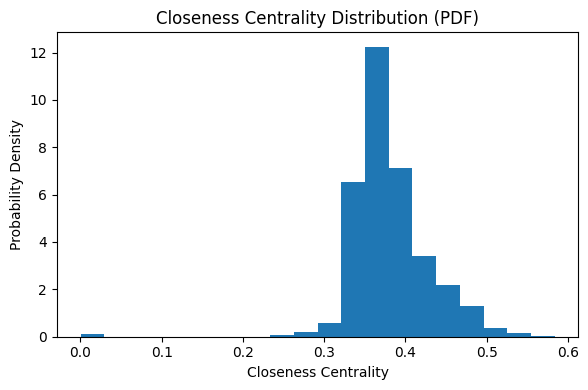

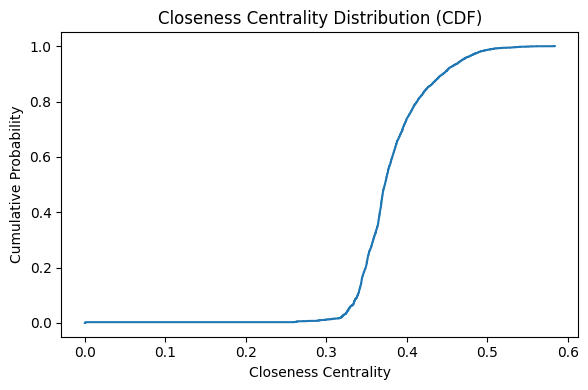

In [58]:
# 6/
deg_cent = nx.degree_centrality(G)
clo_cent = nx.closeness_centrality(G)

deg_vals = np.array(list(deg_cent.values()))
clo_vals = np.array(list(clo_cent.values()))

# --- Degree Centrality PDF ---
plt.figure(figsize=(6,4))
plt.hist(deg_vals, bins=20, density=True)
plt.xlabel('Degree Centrality')
plt.ylabel('Probability Density')
plt.title('Degree Centrality Distribution (PDF)')
plt.tight_layout()
plt.show()

# --- Degree Centrality CDF ---
sorted_deg = np.sort(deg_vals)
cdf_deg = np.arange(1, len(sorted_deg)+1) / len(sorted_deg)
plt.figure(figsize=(6,4))
plt.step(sorted_deg, cdf_deg, where='post')
plt.xlabel('Degree Centrality')
plt.ylabel('Cumulative Probability')
plt.title('Degree Centrality Distribution (CDF)')
plt.tight_layout()
plt.show()

# --- Closeness Centrality PDF ---
plt.figure(figsize=(6,4))
plt.hist(clo_vals, bins=20, density=True)
plt.xlabel('Closeness Centrality')
plt.ylabel('Probability Density')
plt.title('Closeness Centrality Distribution (PDF)')
plt.tight_layout()
plt.show()

# --- Closeness Centrality CDF ---
sorted_clo = np.sort(clo_vals)
cdf_clo = np.arange(1, len(sorted_clo)+1) / len(sorted_clo)
plt.figure(figsize=(6,4))
plt.step(sorted_clo, cdf_clo, where='post')
plt.xlabel('Closeness Centrality')
plt.ylabel('Cumulative Probability')
plt.title('Closeness Centrality Distribution (CDF)')
plt.tight_layout()
plt.show()

In [59]:
# 7/
import sqlite3
import pandas as pd

clust_dict = nx.clustering(G) 

# Save to SQLite database
db_path = 'clustering_alt.db'
conn = sqlite3.connect(db_path)
c = conn.cursor()

c.execute('''
    CREATE TABLE IF NOT EXISTS node_clustering (
        node TEXT PRIMARY KEY,
        clustering_coeff REAL
    )
''')

rows = [(str(node), float(coeff)) for node, coeff in clust_dict.items()]
c.executemany('''
    INSERT OR REPLACE INTO node_clustering (node, clustering_coeff)
    VALUES (?, ?)
''', rows)

conn.commit()
conn.close()

print(f"Saved clustering coefficients for {len(rows)} nodes to '{db_path}'.")

# --- Save to CSV file ---
clust_df = pd.DataFrame(rows, columns=['node', 'clustering_coeff'])
clust_df_sorted = clust_df.sort_values(by='clustering_coeff', ascending=False)
clust_df_sorted.to_csv('clustering_coefficients.csv', index=False)

print("Saved clustering coefficients to 'clustering_coefficients.csv'.")


Saved clustering coefficients for 6426 nodes to 'clustering_alt.db'.
Saved clustering coefficients to 'clustering_coefficients.csv'.


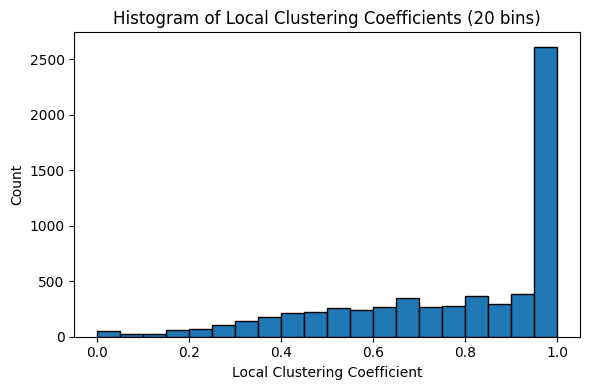

Fitted power‑law:  p(x) ∝ x^(-1.370),  xmin=0.049
Empirical R² of the power‑law fit: -0.6664


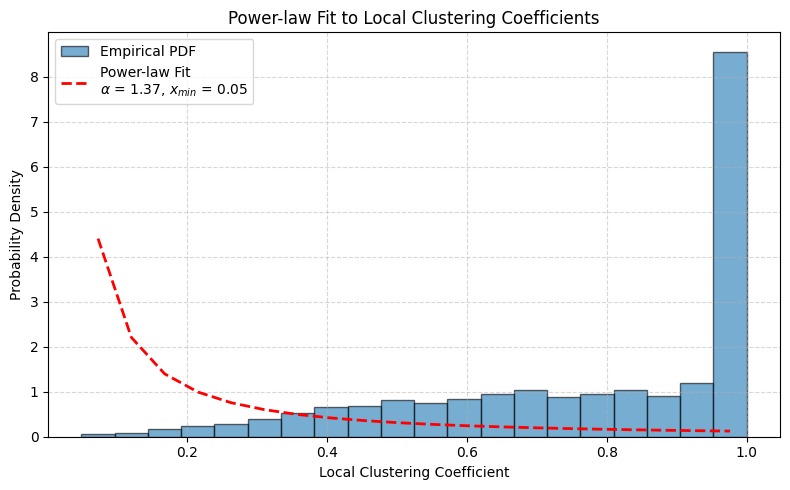

In [83]:
# 8/
import powerlaw
values = np.array(list(clust_dict.values()))

bins = np.linspace(0, 1, 21)
plt.figure(figsize=(6,4))
plt.hist(values, bins=bins, edgecolor='black')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Count')
plt.title('Histogram of Local Clustering Coefficients (20 bins)')
plt.tight_layout()
plt.show()

data = values[values > 0]
fit = powerlaw.Fit(data, xmin=data.min())  
alpha = fit.power_law.alpha
xmin  = fit.power_law.xmin
print(f"Fitted power‑law:  p(x) ∝ x^(-{alpha:.3f}),  xmin={xmin:.3f}")

hist, bin_edges = np.histogram(data, bins=20, range=(xmin, data.max()), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

C = (alpha - 1) * xmin**(alpha - 1)
pdf_theo = C * bin_centers**(-alpha)

y_obs = hist
y_pred = pdf_theo
ss_res = np.sum((y_obs - y_pred)**2)
ss_tot = np.sum((y_obs - y_obs.mean())**2)
r_squared = 1 - ss_res / ss_tot
print(f"Empirical R² of the power‑law fit: {r_squared:.4f}")

# STEP 7: Plot the fit with the histogram
plt.figure(figsize=(8, 5))
plt.hist(data, bins=20, range=(xmin, data.max()), density=True, alpha=0.6, edgecolor='black', label='Empirical PDF')
plt.plot(bin_centers, pdf_theo, 'r--', linewidth=2, label=f'Power-law Fit\n$\\alpha$ = {alpha:.2f}, $x_{{min}}$ = {xmin:.2f}')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Probability Density')
plt.title('Power-law Fit to Local Clustering Coefficients')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

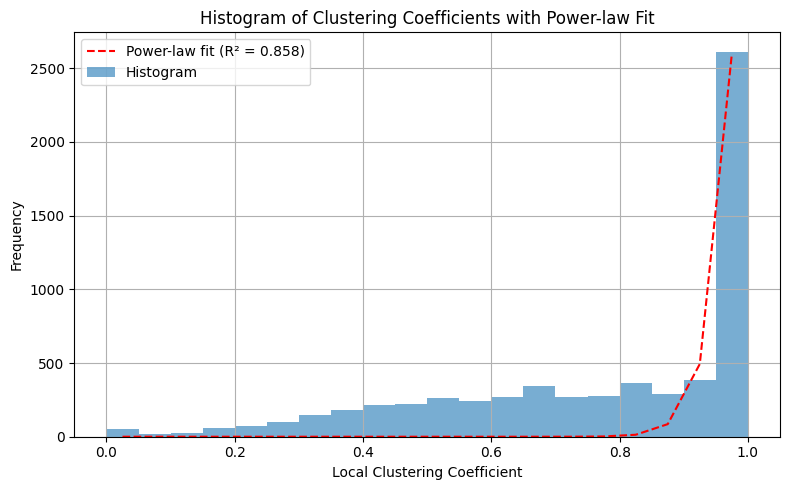

Power-law parameters: a = 5784.408, b = 31.567
R² score: 0.8577


In [87]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Step 0: Assume G is already your undirected NetworkX graph
# Example (comment out if using your own G):
# G = nx.erdos_renyi_graph(1000, 0.01)

# Step 1: Compute local clustering coefficients
clustering_values = list(clust_dict.values())

# Step 2: Create histogram with 20 equal-width bins
num_bins = 20
hist, bin_edges = np.histogram(clustering_values, bins=num_bins, density=False)

# Step 3: Calculate bin centers for fitting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Step 4: Remove bins with 0 count to avoid issues with log-log fitting
nonzero_indices = hist > 0
hist = hist[nonzero_indices]
bin_centers = bin_centers[nonzero_indices]

# Step 5: Define the power-law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Step 6: Fit the power-law to the histogram data
try:
    popt, _ = curve_fit(power_law, bin_centers, hist)
    hist_fitted = power_law(bin_centers, *popt)
    r2 = r2_score(hist, hist_fitted)
except RuntimeError:
    print("Error: Curve fitting failed.")
    popt = [0, 0]
    hist_fitted = np.zeros_like(hist)
    r2 = 0

# Step 7: Plot the histogram and power-law fit
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, label='Histogram')
plt.plot(bin_centers, hist_fitted, 'r--', label=f'Power-law fit (R² = {r2:.3f})')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of Clustering Coefficients with Power-law Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Print fit results
print(f"Power-law parameters: a = {popt[0]:.3f}, b = {popt[1]:.3f}")
print(f"R² score: {r2:.4f}")


In [61]:
#9/
# Compute Hubs and Authorities
hubs, authorities = nx.hits(G, max_iter=1000, normalized=True)

# Convert to DataFrames (optional, for inspection or saving)
import pandas as pd

hits_df = pd.DataFrame({
    'node': list(hubs.keys()),
    'hub_score': list(hubs.values()),
    'authority_score': list(authorities.values())
})

# Sort by highest authority
top_authorities = hits_df.sort_values(by='authority_score', ascending=False).head(10)

# Sort by highest hub
top_hubs = hits_df.sort_values(by='hub_score', ascending=False).head(10)

print("Top 10 Authorities:")
print(top_authorities[['node', 'authority_score']])

print("\nTop 10 Hubs:")
print(top_hubs[['node', 'hub_score']])


Top 10 Authorities:
                    node  authority_score
9        CAPTAIN AMERICA         0.020387
3   THING/BENJAMIN J. GR         0.016853
2   HUMAN TORCH/JOHNNY S         0.016557
4   MR. FANTASTIC/REED R         0.016270
10  IRON MAN/TONY STARK          0.016211
5   INVISIBLE WOMAN/SUE          0.015660
11  SCARLET WITCH/WANDA          0.015330
12               VISION          0.015102
19  THOR/DR. DONALD BLAK         0.014376
14  WASP/JANET VAN DYNE          0.014199

Top 10 Hubs:
                    node  hub_score
9        CAPTAIN AMERICA   0.020387
3   THING/BENJAMIN J. GR   0.016853
2   HUMAN TORCH/JOHNNY S   0.016557
4   MR. FANTASTIC/REED R   0.016270
10  IRON MAN/TONY STARK    0.016211
5   INVISIBLE WOMAN/SUE    0.015660
11  SCARLET WITCH/WANDA    0.015330
12               VISION    0.015102
19  THOR/DR. DONALD BLAK   0.014376
14  WASP/JANET VAN DYNE    0.014199


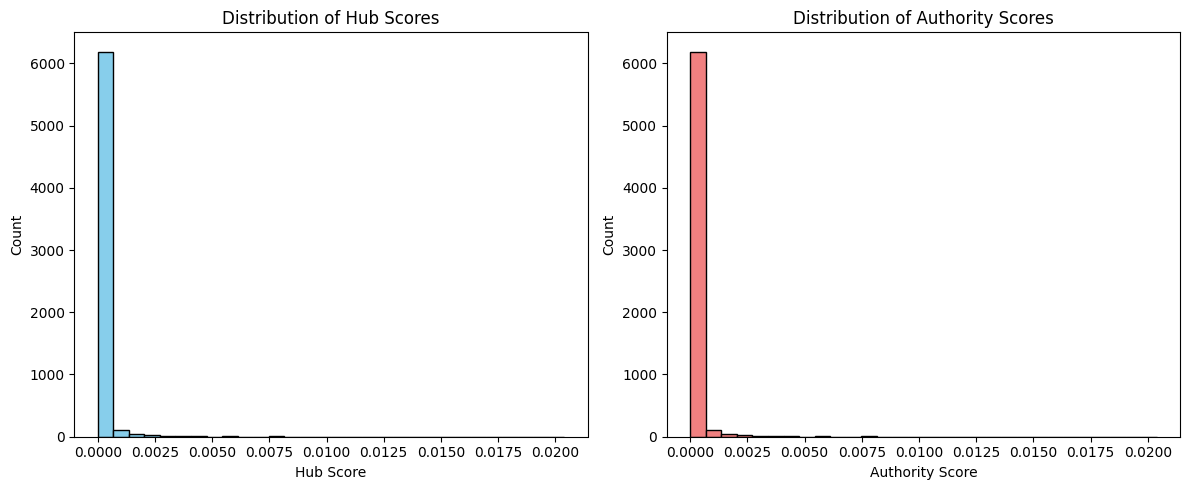

In [69]:
import matplotlib.pyplot as plt

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Hub Score Distribution
axes[0].hist(hits_df['hub_score'], bins=30, edgecolor='black', color='skyblue')
axes[0].set_title('Distribution of Hub Scores')
axes[0].set_xlabel('Hub Score')
axes[0].set_ylabel('Count')

# Plot Authority Score Distribution
axes[1].hist(hits_df['authority_score'], bins=30, edgecolor='black', color='lightcoral')
axes[1].set_title('Distribution of Authority Scores')
axes[1].set_xlabel('Authority Score')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [62]:
#10/
# Run Label Propagation to detect communities
communities = list(nx.algorithms.community.label_propagation_communities(G))

# Map node → community index
node_to_community = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_community[node] = i

# Centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Prepare summary for each community
summary_data = []

for i, comm in enumerate(communities):
    subgraph = G.subgraph(comm)
    sub_deg_centrality = [degree_centrality[n] for n in subgraph.nodes]
    sub_close_centrality = [closeness_centrality[n] for n in subgraph.nodes]
    
    transitivity = nx.transitivity(subgraph)  # global clustering coefficient

    summary_data.append({
        'Community': i,
        'Num Nodes': len(comm),
        'Transitivity': round(transitivity, 4),
        'Avg Degree Centrality': round(pd.Series(sub_deg_centrality).mean(), 5),
        'Std Degree Centrality': round(pd.Series(sub_deg_centrality).std(), 5),
        'Avg Closeness Centrality': round(pd.Series(sub_close_centrality).mean(), 5),
        'Std Closeness Centrality': round(pd.Series(sub_close_centrality).std(), 5),
    })

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data)

# Sort by community ID or number of nodes if desired
summary_df.sort_values(by='Num Nodes', ascending=False, inplace=True)

# Display the summary table
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv('community_summary.csv', index=False)

 Community  Num Nodes  Transitivity  Avg Degree Centrality  Std Degree Centrality  Avg Closeness Centrality  Std Closeness Centrality
         0       5647        0.1966                0.00886                0.01872                   0.38776                   0.04181
         1        118        0.6582                0.00594                0.00412                   0.34573                   0.00468
         5         45        0.6579                0.00499                0.00293                   0.36706                   0.02807
        13         40        0.6577                0.00275                0.00128                   0.34366                   0.00475
         4         33        0.7752                0.00459                0.00203                   0.35969                   0.01177
         2         32        0.6000                0.00204                0.00135                   0.33195                   0.03784
        17         30        0.8383                0.00341    

In [63]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms.community import label_propagation_communities
from scipy.stats import levene

# Load graph from edge list
df = pd.read_csv('hero-network.csv')  # adjust path as needed
G = nx.from_pandas_edgelist(df, 'hero1', 'hero2')

# Convert to directed graph for HITS algorithm
G_dir = G.to_directed()

# 1. Community detection using label propagation
communities = list(label_propagation_communities(G))
community_map = {}  # node -> community_id
for i, comm in enumerate(communities):
    for node in comm:
        community_map[node] = i

# 2. Compute HITS scores
hubs, authorities = nx.hits(G_dir, max_iter=1000, normalized=True)

# 3. Group HITS scores by community
community_scores = {}
for node, cid in community_map.items():
    if cid not in community_scores:
        community_scores[cid] = {'hub': [], 'auth': []}
    if node in hubs and node in authorities:
        community_scores[cid]['hub'].append(hubs[node])
        community_scores[cid]['auth'].append(authorities[node])

# 4. Summarize community statistics
summary = []
valid_hub_groups = []
valid_auth_groups = []

for cid, scores in community_scores.items():
    if len(scores['hub']) < 2:
        continue  # Skip very small communities
    hub_std = np.std(scores['hub'])
    auth_std = np.std(scores['auth'])
    hub_mean = np.mean(scores['hub'])
    auth_mean = np.mean(scores['auth'])
    
    valid_hub_groups.append(scores['hub'])
    valid_auth_groups.append(scores['auth'])

    summary.append({
        'community_id': cid,
        'size': len(scores['hub']),
        'hub_mean': hub_mean,
        'hub_std': hub_std,
        'authority_mean': auth_mean,
        'authority_std': auth_std
    })

# 5. Save summary statistics
summary_df = pd.DataFrame(summary)
summary_df.sort_values(by='size', ascending=False, inplace=True)
summary_df.to_csv('community_hub_authority_analysis.csv', index=False)
print("Top communities by size with hub/authority summary:")
print(summary_df.head(10))

# 6. Hypothesis test: Levene's test on intra-community variance
hub_stat, hub_p = levene(*valid_hub_groups)
auth_stat, auth_p = levene(*valid_auth_groups)

print("\nLevene’s Test Results:")
print(f"Hub scores p-value: {hub_p:.10f}")
print(f"Authority scores p-value: {auth_p:.10f}")

if hub_p < 0.05:
    print("→ Significant difference in hub score variances across communities.")
else:
    print("→ No significant difference in hub score variances across communities.")

if auth_p < 0.05:
    print("→ Significant difference in authority score variances across communities.")
else:
    print("→ No significant difference in authority score variances across communities.")


Top communities by size with hub/authority summary:
    community_id  size  hub_mean   hub_std  authority_mean  authority_std
0              0  5627  0.000176  0.000295        0.000176       0.000295
21            21   118  0.000012  0.000006        0.000012       0.000006
35            35    45  0.000057  0.000046        0.000057       0.000046
3              3    40  0.000011  0.000005        0.000011       0.000005
9              9    33  0.000042  0.000023        0.000042       0.000023
32            32    32  0.000008  0.000005        0.000008       0.000005
1              1    30  0.000025  0.000011        0.000025       0.000011
38            38    23  0.000004  0.000002        0.000004       0.000002
19            19    21  0.000007  0.000004        0.000007       0.000004
65            65    19  0.000004  0.000001        0.000004       0.000001

Levene’s Test Results:
Hub scores p-value: 0.0000000024
Authority scores p-value: 0.0000000024
→ Significant difference in hub score 

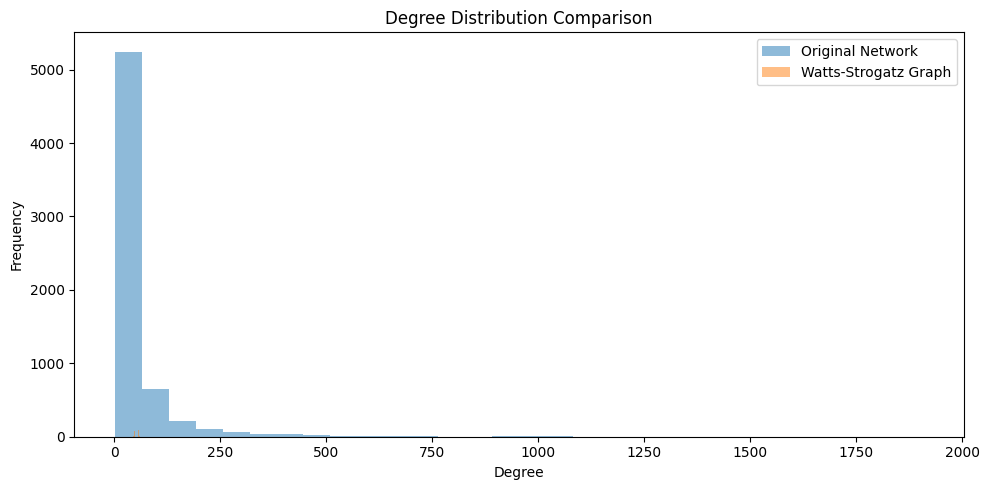

Generated Watts-Strogatz graph with 6426 nodes and k=52, p=0.1


In [64]:
#12/

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load original network
df = pd.read_csv('hero-network.csv')
G = nx.from_pandas_edgelist(df, 'hero1', 'hero2')
num_nodes = G.number_of_nodes()
degree_sequence = [d for _, d in G.degree()]
avg_degree = int(np.mean(degree_sequence))

# Ensure even k for Watts-Strogatz model
k = avg_degree if avg_degree % 2 == 0 else avg_degree + 1

# Generate small-world network
p = 0.1  # rewiring probability
G_ws = nx.watts_strogatz_graph(n=num_nodes, k=k, p=p)

# Compare degree distribution
original_deg = [d for _, d in G.degree()]
ws_deg = [d for _, d in G_ws.degree()]

plt.figure(figsize=(10, 5))
plt.hist(original_deg, bins=30, alpha=0.5, label='Original Network')
plt.hist(ws_deg, bins=30, alpha=0.5, label='Watts-Strogatz Graph')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution Comparison')
plt.legend()
plt.tight_layout()
plt.savefig('degree_distribution_comparison.png')
plt.show()

# Save the generated graph to edge list
nx.write_edgelist(G_ws, 'watts_strogatz_graph.edgelist')
print(f"Generated Watts-Strogatz graph with {num_nodes} nodes and k={k}, p={p}")
